## Weight  of evidence

Weight of Evidence (WoE) was developed primarily for the credit and financial industries to help build more predictive models to evaluate the risk of loan default. That is, to predict how likely the money lent to a person or institution is to be lost. Thus, Weight of Evidence is a measure of the "strength” of a grouping technique to separate good and bad risk (default). 

- WoE will be 0 if the P(Goods) / P(Bads) = 1, that is, if the outcome is random for that group.
- If P(Bads) > P(Goods) the odds ratio will be < 1 and,
- WoE will be < 0 if,  P(Goods) > P(Bads).

WoE is well suited for Logistic Regression, because the Logit transformation is simply the log of the odds, i.e., ln(P(Goods)/P(Bads)). Therefore, by using WoE-coded predictors in logistic regression, the predictors are all prepared and coded to the same scale, and the parameters in the linear logistic regression equation can be directly compared.

The WoE transformation has three advantages:

- It creates a monotonic relationship between the target and the independent variables.
- It orders the categories on a "logistic" scale which is natural for logistic regression
- The transformed variables can then be compared because they are on the same scale. Therefore, it is possible to determine which one is more predictive.

The WoE also has a limitation:

- Prone to cause over-fitting


For more details follow this [article](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html#Steps-of-Calculating-WOE) and this [article](https://blogs.oracle.com/r/computing-weight-of-evidence-woe-and-information-value-iv).


## In this demo:

We will see how to perform one hot encoding with:
- pandas
- Feature-Engine
- Category encoders

And the advantages and limitations of each implementation using the Titanic dataset.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split

# for encoding using feature-engine
from feature_engine.categorical_encoders import WoERatioCategoricalEncoder
from category_encoders.woe import WOEEncoder

In [2]:
# load dataset

data = pd.read_csv(
    '../titanic.csv',
    usecols=['cabin', 'sex', 'embarked', 'survived'])

data.head()

,survived,sex,cabin,embarked
0,1,female,B5,S
1,1,male,C22,S
2,0,female,C22,S
3,0,male,C22,S
4,0,female,C22,S


In [3]:
# let's remove observations with na in embarked

data.dropna(subset=['embarked'], inplace=True)
data.shape

(1307, 4)

In [4]:
# Now we extract the first letter of the cabin
# to create a simpler variable for the demo

data['cabin'] = data['cabin'].astype(str).str[0]

In [5]:
# and we remove the observations where cabin = T
# because only few observations show T in the dataset

data = data[data['cabin']!= 'T']
data.shape

(1306, 4)

In [6]:
# let's have a look at how many labels each variable has

for col in data.columns:
    print(col, ': ', len(data[col].unique()), ' labels')

survived :  2  labels
sex :  2  labels
cabin :  8  labels
embarked :  3  labels


In [7]:
# let's explore the unique categories
data['cabin'].unique()

array(['B', 'C', 'E', 'D', 'A', 'n', 'F', 'G'], dtype=object)

In [8]:
data['sex'].unique()

array(['female', 'male'], dtype=object)

In [9]:
data['embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

### Encoding important

We select calculate the woe using the train set, and then use those mappings in the test set.

Note that in the pandas implementation, we need to keep the target in the training set

In [10]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked', 'survived']],  # this time we keep the target!!
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((914, 4), (392, 4))

### Explore original relationship between categorical variables and target

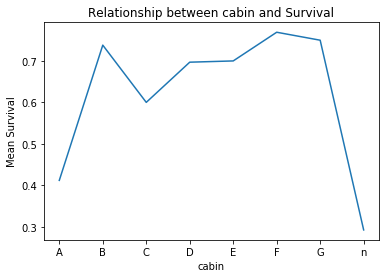

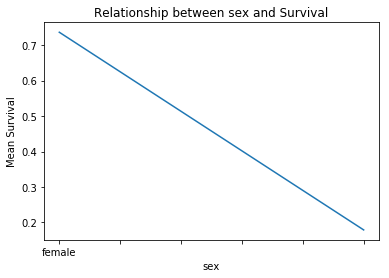

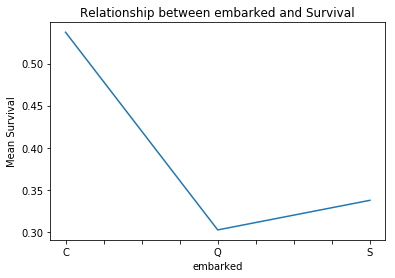

In [11]:
# let's explore the relationship of the categories with the target

for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survival')
    plt.show()

You can see that the relationship between the target and cabin and embarked goes up and down, depending on the category.


## Weight of Evidence with pandas


### Advantages

- quick
- returns pandas dataframe

### Limitations of pandas:

- it does not preserve information from train data to propagate to test data

We need to store the mappings separately if planning to use the model in production.

In [12]:
# let's calculate the proportion of passengers who survived
# over the total survivors, per category of cabin

# total survivors
total_survived = X_train['survived'].sum()

# percentage of passenges who survived, from total survivors
# per category of cabin
survived = X_train.groupby(['cabin'])['survived'].sum() / total_survived

survived

cabin
A    0.020408
B    0.090379
C    0.122449
D    0.067055
E    0.061224
F    0.029155
G    0.008746
n    0.600583
Name: survived, dtype: float64

In [13]:
# let's calculate the proportion of passengers who did not survive
# over the total passengers who didn't, per category of cabin

# total passengers who did not survive
total_non_survived = len(X_train) - X_train['survived'].sum()

# let's create a flag for passenges who did not survive
X_train['non_survived'] = np.where(X_train['survived'] == 1, 0, 1)

# now let's calculate the % of passengers who did not survive
# per category of cabin
non_survived = X_train.groupby(
    ['cabin'])['non_survived'].sum() / total_non_survived

non_survived

cabin
A    0.017513
B    0.019264
C    0.049037
D    0.017513
E    0.015762
F    0.005254
G    0.001751
n    0.873905
Name: non_survived, dtype: float64

In [14]:
#  now let's combine those 2 series in a dataframe and calculate the
# WoE

# let's concatenate the series in a dataframe
prob_df = pd.concat([survived, non_survived], axis=1)

# let's calculate the Weight of Evidence
prob_df['woe'] = np.log(prob_df['survived']/prob_df['non_survived'])

prob_df

,survived,non_survived,woe
cabin,,,
A,0.020408,0.017513,0.152984
B,0.090379,0.019264,1.545751
C,0.122449,0.049037,0.915124
D,0.067055,0.017513,1.342568
E,0.061224,0.015762,1.356957
F,0.029155,0.005254,1.713632
G,0.008746,0.001751,1.608271
n,0.600583,0.873905,-0.375071


In [15]:
# and now let's capture the woe in a dictionary

ordered_labels = prob_df['woe'].to_dict()

ordered_labels

{'A': 0.1529838185513379,
 'B': 1.545750694176846,
 'C': 0.9151238705982346,
 'D': 1.3425678854251744,
 'E': 1.356956622877274,
 'F': 1.7136315668160063,
 'G': 1.60827105115818,
 'n': -0.37507116447186734}

In [16]:
# now, we replace the labels with the woe

X_train['cabin'] = X_train['cabin'].map(ordered_labels)
X_test['cabin'] = X_test['cabin'].map(ordered_labels)

In [17]:
# let's explore the result

X_train['cabin'].head(10)

843    -0.375071
869    -0.375071
430    -0.375071
481    -0.375071
1308   -0.375071
456    -0.375071
118     1.342568
485     1.342568
297    -0.375071
263     1.356957
Name: cabin, dtype: float64

In [18]:
# we can turn the previous commands into 2 functions


def find_category_mappings(df, variable, target):

    # copy of the original dataframe, so we do not accidentally modify it
    tmp = df.copy()

    # total positive class
    total_pos = df[target].sum()

    # total negative class
    total_neg = len(df) - df[target].sum()

    # non target
    tmp['non-target'] = 1 - tmp[target]

    # % of positive class per category, respect to total positive class
    pos_perc = tmp.groupby([variable])[target].sum() / total_pos

    # % of negative class per category, respect to total negative class
    neg_perc = tmp.groupby([variable])['non-target'].sum() / total_neg

    # let's concatenate
    prob_tmp = pd.concat([pos_perc, neg_perc], axis=1)

    # let's calculate the Weight of Evidence
    prob_tmp['woe'] = np.log(prob_tmp[target]/prob_tmp['non-target'])

    return prob_tmp['woe'].to_dict()


def integer_encode(train, test, variable, ordinal_mapping):

    X_train[variable] = X_train[variable].map(ordinal_mapping)

    X_test[variable] = X_test[variable].map(ordinal_mapping)

In [19]:
# and now we run a loop over the remaining categorical variables

for variable in ['sex', 'embarked']:

    mappings = find_category_mappings(X_train, variable, 'survived')

    integer_encode(X_train, X_test, variable, mappings)

In [20]:
# let's see the result

X_train.head()

,cabin,sex,embarked,survived,non_survived
843,-0.375071,-1.013111,-0.164796,0,1
869,-0.375071,-1.013111,-0.164796,0,1
430,-0.375071,1.535068,-0.164796,1,0
481,-0.375071,1.535068,0.658871,1,0
1308,-0.375071,-1.013111,-0.164796,0,1


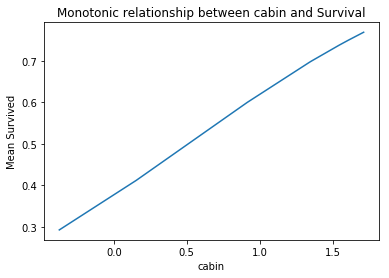

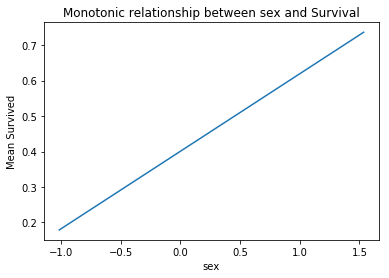

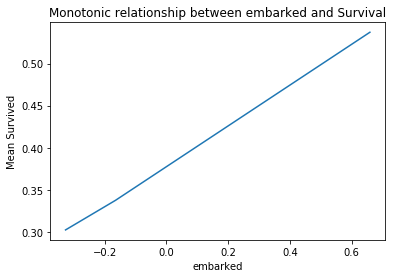

In [21]:
# let's inspect the newly created monotonic relationship
# between the categorical variables and the target

# first in the train set
for var in ['cabin', 'sex', 'embarked']:

    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Monotonic relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survived')
    plt.show()

Note the monotonic relationships between the mean target and the categories. In the train set.

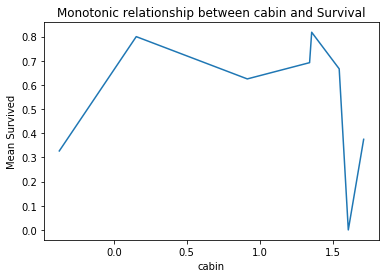

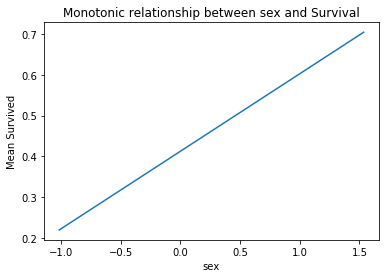

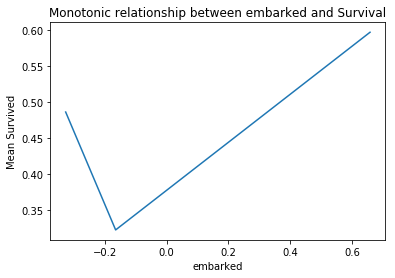

In [22]:
# now in the test set
for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_test.groupby([var])['survived'].mean().plot()
    fig.set_title('Monotonic relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survived')
    plt.show()

The monotonic relationship does not hold when encoding the categorical variables in the test set. This could mean that the categories are not informative of the target or the proportion of survivors is not homogeneous between in the categories in the train and test sets. 

In situations like this, we could try grouping rare labels into a joint category as we will cover later in this section, before applying the Weight of evidence transformation.

### Note

Replacing categorical labels with this code and method will generate missing values for categories present in the test set that were not seen in the training set. Therefore it is extremely important to handle rare labels before-hand. I will explain how to do this, in a later notebook.

**In addition, it will create NA or Inf if any of the 2 terms in the ratio of the WoE formula are 0**

## Weight of Evidence with Feature-Engine

If using Feature-Engine, instead of pandas, we do not need to keep the target variable in the training dataset.

In [23]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked']],  # predictors
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((914, 3), (392, 3))

In [24]:
woe_enc = WoERatioCategoricalEncoder(
    encoding_method = 'woe',
    variables=['cabin', 'sex', 'embarked'])

In [25]:
# when fitting the transformer, we need to pass the target as well
# just like with any Scikit-learn predictor class

woe_enc.fit(X_train, y_train)

WoERatioCategoricalEncoder(variables=['cabin', 'sex', 'embarked'])

In [26]:
# in the encoder dict we see the woe for each category
# for each of the selected variables

woe_enc.encoder_dict_

{'cabin': {'A': 0.1529838185513379,
  'B': 1.545750694176846,
  'C': 0.9151238705982346,
  'D': 1.3425678854251744,
  'E': 1.356956622877274,
  'F': 1.7136315668160063,
  'G': 1.60827105115818,
  'n': -0.37507116447186734},
 'sex': {'female': 1.535067647134885, 'male': -1.0131107672983564},
 'embarked': {'C': 0.658871160676746,
  'Q': -0.3265892617105483,
  'S': -0.16479628505772237}}

In [27]:
# this is the list of variables that the encoder will transform

woe_enc.variables

['cabin', 'sex', 'embarked']

In [28]:
X_train = woe_enc.transform(X_train)
X_test = woe_enc.transform(X_test)

# let's explore the result
X_train.head()

,cabin,sex,embarked
843,-0.375071,-1.013111,-0.164796
869,-0.375071,-1.013111,-0.164796
430,-0.375071,1.535068,-0.164796
481,-0.375071,1.535068,0.658871
1308,-0.375071,-1.013111,-0.164796


**Note**

If the argument variables is left to None, then the encoder will automatically identify all categorical variables. Is that not sweet?

The encoder will not encode numerical variables. So if some of your numerical variables are in fact categories, you will need to re-cast them as object before using the encoder.

If there is a label in the test set that was not present in the train set, the encoder will through and error, to alert you of this behaviour.

Finally, if any of the terms in the weight of evidence calculation is 0, the log of 0 is not defined, so this transformer will raise an error.

## Weight of Evidence with Category Encoders

If using Category encpders, instead of pandas, we do not need to keep the target variable in the training dataset.

In [29]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked']],  # predictors
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((914, 3), (392, 3))

In [30]:
woe_enc = WOEEncoder(cols=['cabin', 'sex', 'embarked'])

In [36]:
woe_enc.fit(X_train, y_train)

C:\Users\bberry\AppData\Local\Continuum\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


WOEEncoder(cols=['cabin', 'sex', 'embarked'])

In [35]:
# the mappings in category encoders are not so easy to interpret

woe_enc.mapping

In [37]:
X_train = woe_enc.transform(X_train)
X_test = woe_enc.transform(X_test)

# let's explore the result
X_train.head()

,cabin,sex,embarked
843,-0.374548,-1.008094,-0.164851
869,-0.374548,-1.008094,-0.164851
430,-0.374548,1.525265,-0.164851
481,-0.374548,1.525265,0.654977
1308,-0.374548,-1.008094,-0.164851
